### Import libraries

In [2]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_bmimBF4_PR import configuration

### Create model

In [3]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

2021-04-27 22:13:38 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [4]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [5]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "bmimBF4"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [6]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

### Get flash data

In [8]:
# Set pressures to loop over
P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.01,0.15,0.2,0.3,0.4,0.5,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "bmimBF4"].fix(0.15)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL) 
        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "bmimBF4"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

Running pressure: 200000 and HFC feed fraction 0.01
Running pressure: 200000 and HFC feed fraction 0.15
Running pressure: 200000 and HFC feed fraction 0.2
Running pressure: 200000 and HFC feed fraction 0.3
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.5
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 300000 and HFC feed fraction 0.01
Running pressure: 300000 and HFC feed fraction 0.15
Running pressure: 300000 and HFC feed fraction 0.2
Running pressure: 300000 and HFC feed fraction 0.3
Running pressure: 300000 and HFC feed fraction 0.4
Running pressure: 300000 and HFC feed fraction 0.5
Running pressure: 300000 and HFC feed fraction 0.72
Running pressure: 300000 and HFC feed fraction 0.91
Running pressure: 300000 and HFC feed fraction 0.99
Running pressure: 400000 and HFC feed fraction 0.01
Running pressure: 40

In [9]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[86.41921799 86.69291803 86.79134386 86.9892955  87.1887526  87.38976272
  87.83769362 88.23119681 88.39882291]
 [80.13162979 80.47902111 80.60422062 80.85648576 81.11133427 81.36888405
  81.94561205 82.45576181 82.67415362]
 [74.14997248 74.53550359 74.67454021 74.95487313 75.2383786  75.52525618
  76.16930529 76.74135088 76.98704027]
 [68.45072194 68.84375225 68.98523933 69.27014338 69.55781666 69.84850527
  70.49993824 71.07765079 71.32565302]
 [63.00880558 63.38355233 63.51766658 63.78646008 64.05615756 64.3269431
  64.92744024 65.45265512 65.67600367]
 [57.79710451 58.13259106 58.25108611 58.48597225 58.71800778 58.94710732
  59.44010154 59.85220386 60.02136159]
 [52.78556183 53.06563155 53.16186975 53.3480402  53.52533339 53.69306734
  54.02399405 54.25939703 54.34153819]
 [47.93959104 48.15310181 48.22213803 48.34796891 48.45627888 48.54533262
  48.6621163  48.65389008 48.61211426]
 [43.21713971 43.35857877 43.39736651 43.45482853 43.48317786 43.47904964
  43.33309061 43

##### Store

In [10]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

In [11]:
# points_y = []

# for i in range(len(P)):
#     for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
#         points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
#         points_x.append(points)

### Ternary Diagram

points 1 are: [(86.41921799263828, 13.467330224646004, 0.11345178271571779), (86.69291802590068, 11.600808563699582, 1.7062734103997304), (86.79134385936068, 10.931434389401733, 2.277221751237593), (86.9892955006871, 9.588178685091044, 3.4225258142218573), (87.18875259666507, 8.238737651291714, 4.572509752043208), (87.38976271697348, 6.8828978617422685, 5.727339421284255), (87.8376936243546, 3.8764530164519235, 8.28585335919348), (88.23119680817972, 1.252386631682484, 10.516416560137813), (88.39882290791357, 0.13946086501119564, 11.461716227075236)]
points 2 are: [(80.13162978769174, 19.700657559845595, 0.16771265246268227), (80.47902111436743, 16.995496826651035, 2.5254820589815523), (80.60422061953277, 16.02366551426901, 3.3721138661982426), (80.856485757596, 14.070590062994654, 5.072924179409339), (81.11133426830709, 12.104483254472465, 6.7841824772204475), (81.36888405109056, 10.1247552969994, 8.506360651910027), (81.94561205044859, 5.718399539475611, 12.335988410075823), (82.45576

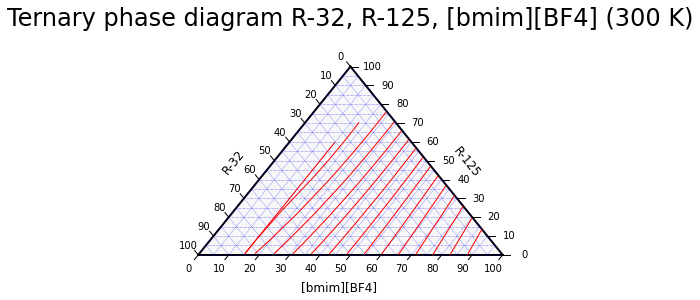

In [12]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [bmim][BF4] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[bmim][BF4]", fontsize=fontsize, offset=offset)

# color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
#     color = color_options[i]
    if P[i]<=1400000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-9:9*i], linewidth=1., color='red', linestyle="-")
    elif P[i]==1500000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-8:9*i], linewidth=1., color='red', linestyle="-")
    else:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-6:9*i], linewidth=1., color='red', linestyle="-")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()